In [1]:
import numpy as np
import numpy.ma as ma
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset
import umap
import seaborn as sns
from models import GIN, HeteroGIN, Classifier, Discriminator, MLP, Concatenate, MLP_SIGMOID
from utils import GraphDataset, get_graph_dataset_info, load_graph_dataset
reducer = umap.UMAP();
import matplotlib.pyplot as plt
extractor = None
latent_repr = None


/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

In [2]:
plt.rc('font', size=15) #controls default text size                                                                                                                     
plt.rc('axes', titlesize=25) #fontsize of the title                                                                                                                     
plt.rc('axes', labelsize=25) #fontsize of the x and y labels                                                                                                            
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels                                                                                                            
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels                                                                                                            
plt.rc('legend', fontsize=15) #fontsize of the legend
figsize = (16,10) #NOTE: ADDED 9/30/22

In [3]:
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"
dataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"
max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=dataset, prefix=prefix)
nclasses = 2
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using Device: {device}")
test_dataset = GraphDataset(prefix+dataset)
test_dataset.load()
test_dataset = Subset(test_dataset,range(int(min(len(test_dataset),max_events)*split)))

Using Device: cuda:0


In [4]:
# indices = [10,10,80]
# train_dataloader, val_dataloader, eval_loader, nclasses, nfeatures, nfeatures_edge = load_graph_dataset(dataset=dataset, prefix=prefix, 
#                                                     split=split, max_events=max_events, indices=indices,
#                                                     num_workers=nworkers, batch_size=batch)
model = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
model.load_state_dict(torch.load("logs/model_weights",map_location=device))
# def get_features(name):
#     def hook(model, input, output):
#         features[name] = output.detach()
#     return hook

<All keys matched successfully>

In [5]:
extractor = model
test_bg = dgl.batch(test_dataset.dataset.graphs[test_dataset.indices.start:test_dataset.indices.stop])
test_bg = test_bg.to(device)

In [6]:
latent_repr = extractor.get_latent_repr(test_bg).detach().cpu()

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


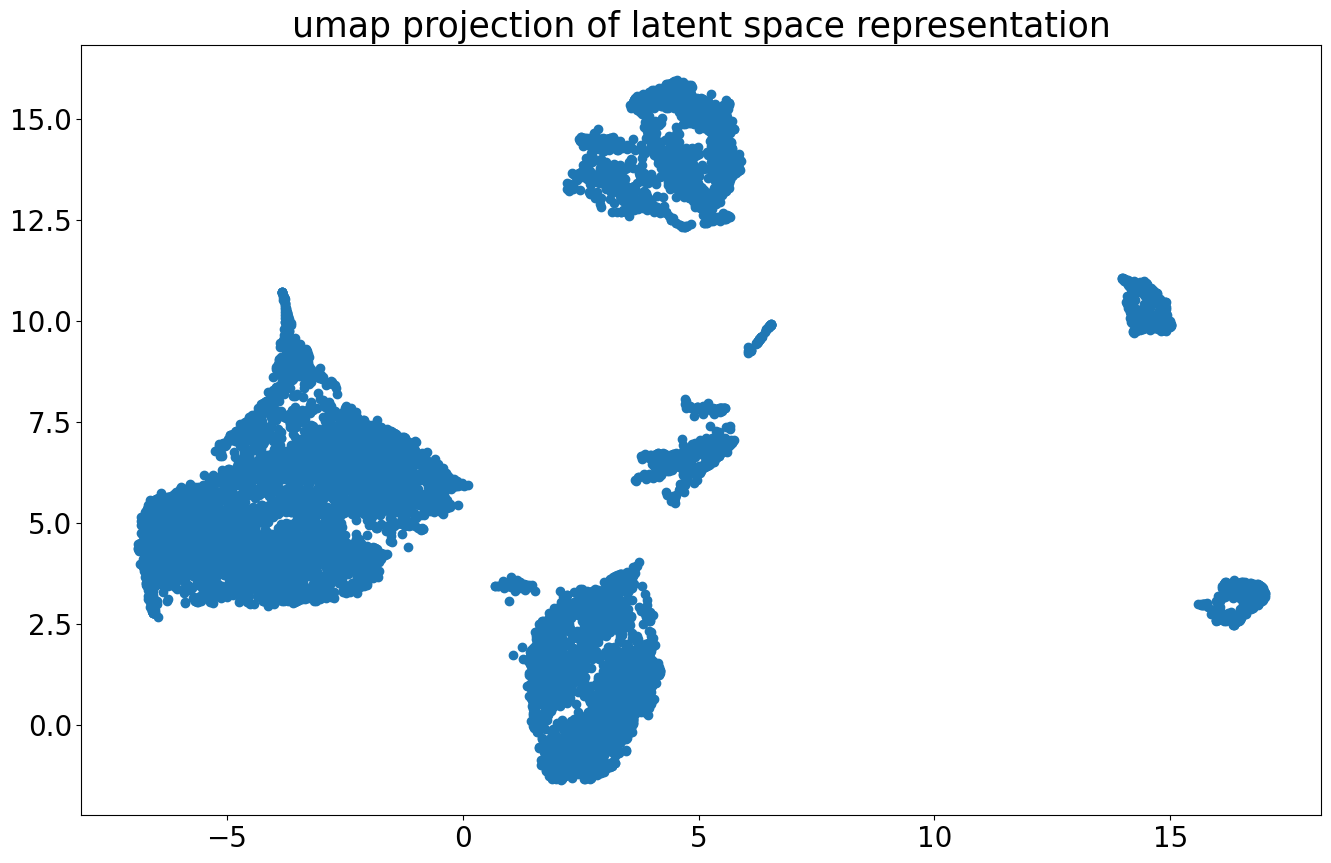

In [9]:
embedding = reducer.fit_transform(latent_repr)
visualization_method = 'umap'
f = plt.figure(figsize=figsize)
plt.scatter(embedding[:,0],embedding[:,1])
plt.title(visualization_method+' projection of latent space representation')
plt.savefig("latent.png")

In [119]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.num_layers = model.num_layers
        self.learn_eps = model.learn_eps

        # List of MLPs
        self.ginlayers = model.ginlayers
        self.batch_norms = model.batch_norms
        self.drop = model.drop

        self.pool = model.pool
    def forward(self, g):
        h = g.ndata['data'].float()
        hidden_rep = [h]
        for i in range(self.num_layers - 1):
            h = self.ginlayers[i](g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        for i, h in enumerate(hidden_rep):
            print(h.size())
            pooled_h = self.pool(g,h)
            score_over_layer += self.drop(pooled_h)
        return pooled_h
        

In [120]:
new_model = FeatureExtractor(model)
new_model = new_model.to(device)

In [121]:
# model.ginlayers.register_forward_hook(get_features('feats'))

In [122]:
new_model.eval()
test_bg = dgl.batch(test_dataset.dataset.graphs[test_dataset.indices.start:test_dataset.indices.stop])
test_bg = test_bg.to(device)

In [123]:
outs = new_model(test_bg)

torch.Size([76940, 7])
torch.Size([76940, 64])


RuntimeError: The size of tensor a (7) must match the size of tensor b (64) at non-singleton dimension 1

In [17]:
print(new_model)

FeatureExtractor(
  (ginlayers): ModuleList(
    (0): GINConv(
      (apply_func): ApplyNodeFunc(
        (mlp): MLP(
          (linears): ModuleList(
            (0): Linear(in_features=7, out_features=64, bias=True)
            (1-2): 2 x Linear(in_features=64, out_features=64, bias=True)
          )
          (batch_norms): ModuleList(
            (0-1): 2 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [22]:
print(outs[0])

tensor([[ 0.6513,  1.2708,  0.0753,  ...,  0.0045, -1.0000, -0.4462],
        [-0.3004,  0.1416,  0.0492,  ..., -0.0021, -0.6000,  0.4200],
        [ 0.1635, -0.6249,  0.1601,  ...,  0.0119,  0.8000,  0.4240],
        ...,
        [ 0.1515,  0.6072,  0.4188,  ...,  0.1000,  0.5000,  0.4020],
        [-0.0545,  0.4778,  0.2929,  ...,  0.1000,  0.5000,  0.4020],
        [-0.5291, -0.4403, -0.5267,  ...,  0.1000,  0.0000,  0.4020]],
       device='cuda:0')


In [ ]:
PREDS = []
FEATS = []

features ={}
preds = model(test_bg)
PREDS.append(preds.detach().cpu().numpy())
FEATS.append(features['feats'].cpu().numpy())

In [ ]:
print(model.batch_norms)

In [ ]:
#Need to input model w/ Validation data
extractor = model
latent_repr = extractor(test_bg).detach().to("cpu")

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_repr)

In [ ]:
f = plt.figure(figsize=figsize)
plt.scatter(embedding[:,0],embedding[:,1])
plt.title("UMAP"+' projection of the '+"GIN"+' latent space presentation')